In [1]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")

print("Path to dataset files:", path)

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 956.3 kB/s  0:00:001.8 MB/s eta 0:00:01
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached idna-3.11-py3-none-any.whl (71 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached certifi-2025.11.12-py3-none-any.whl (159 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [kagglehub]━ 7/8 [kagglehub]


/home/saba/data_managemnet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 228M/228M [00:52<00:00, 4.53MB/s] 

Extracting files...


Path to dataset files: /home/saba/.cache/kagglehub/datasets/rounakbanik/the-movies-dataset/versions/7


  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 3.3 MB/s  0:00:02 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 3.5 MB/s  0:00:02 eta 0:00:010:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.9 MB/s  0:00:014.8 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.0 MB/s  0:00:00m 5.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 5.4 MB/s  0:00:01m 6.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 4.4 MB/s  0:00:08 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

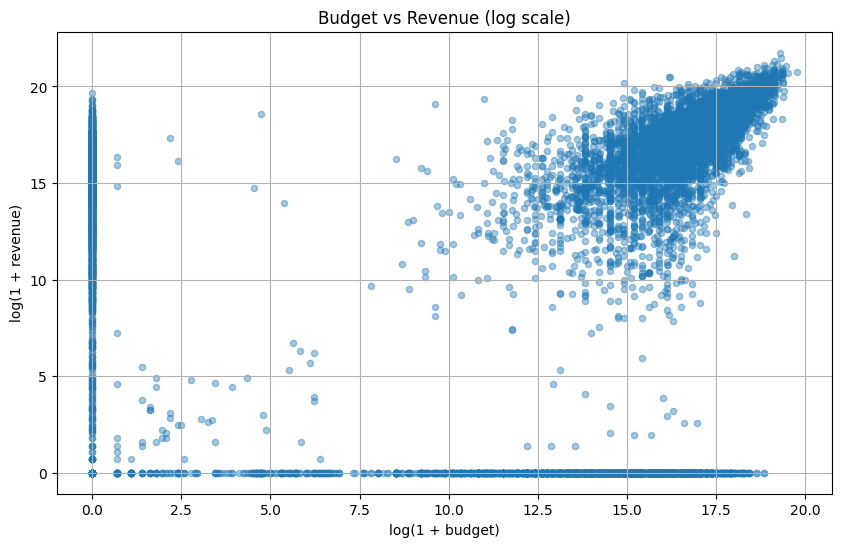

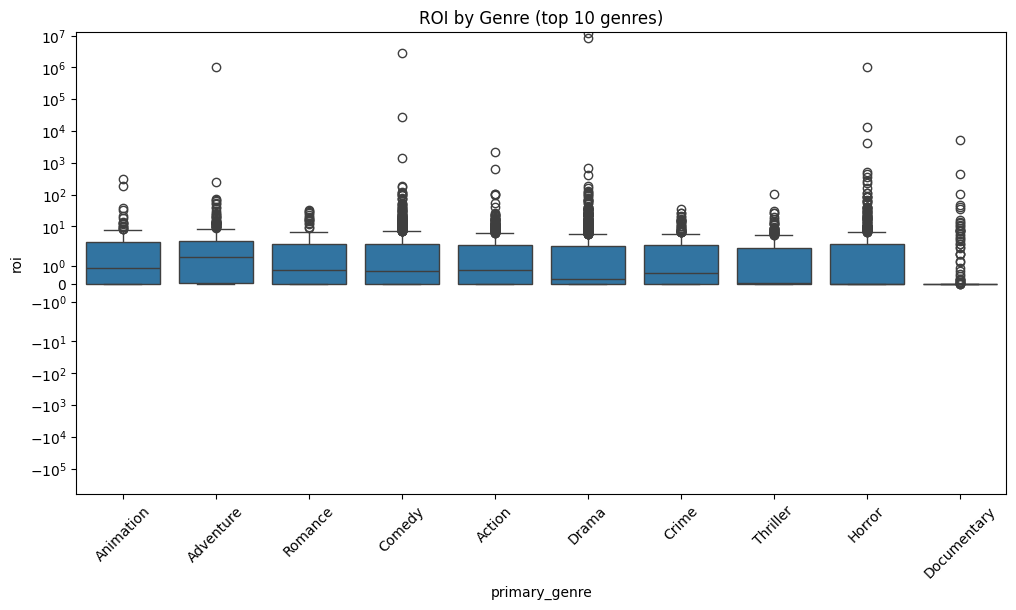

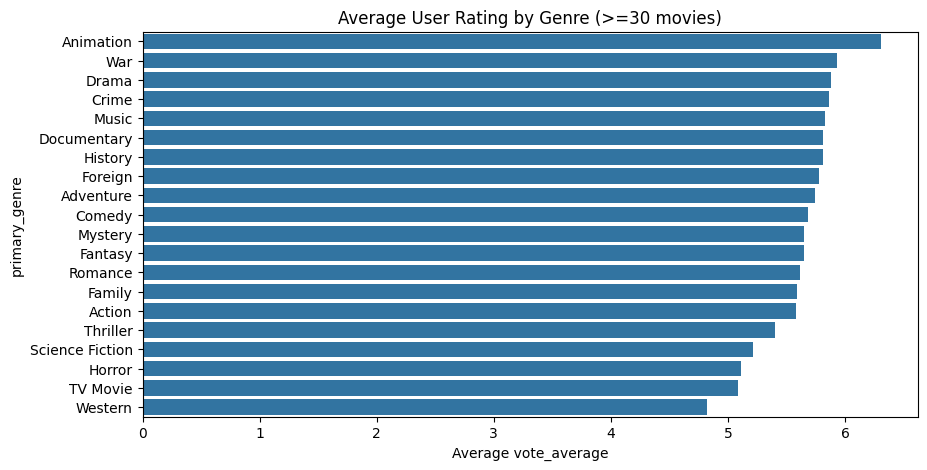

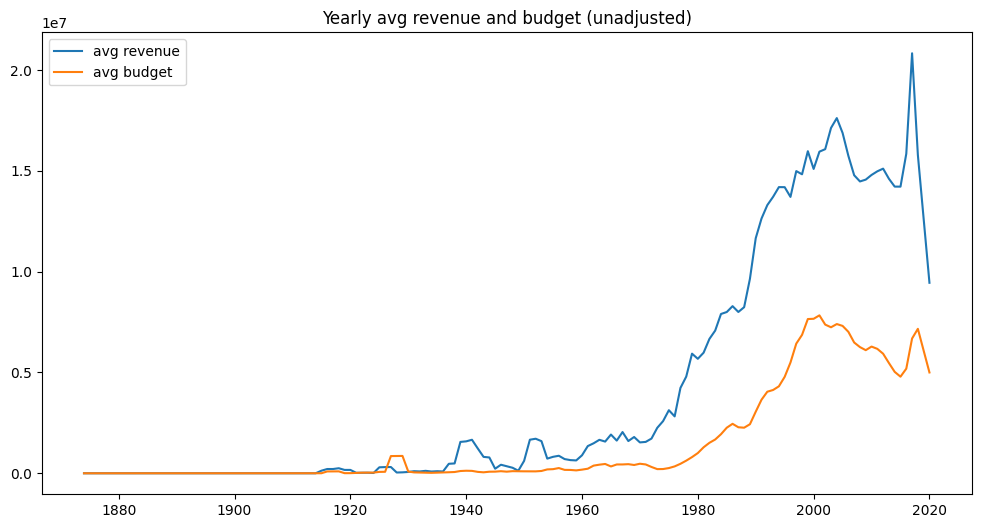

RMSE: 3.6809733189619536
R2: 0.623778215801569
log_budget      0.691437
vote_count      0.262820
year            0.024206
runtime         0.016479
vote_average    0.005058
dtype: float64


In [7]:

!pip install pandas numpy matplotlib seaborn scikit-learn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# --- LOAD DATA ---
# Replace 'movies.csv' with your dataset file (TMDB or similar)
df = pd.read_csv(path+'/movies_metadata.csv', low_memory=False)

# --- BASIC CLEANING ---
# Parse date
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df = df[df['year'].notna()]  # remove rows without year

# Numeric conversions
for col in ['budget','revenue','runtime','vote_average','vote_count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter obviously bad rows (optional)
df = df[(df['revenue'].notna()) & (df['budget'].notna())]

# Create profit & log versions
df['profit'] = df['revenue'] - df['budget']
df['log_revenue'] = np.log1p(df['revenue'])
df['log_budget'] = np.log1p(df['budget'])
df['roi'] = df['revenue'] / (df['budget'].replace(0, np.nan))

# Genre handling (TMDB style: a JSON-like string or list)
# Example: if 'genres' is a string of dicts, transform to list of names
import ast
def extract_primary_genre(x):
    try:
        genlist = ast.literal_eval(x) if isinstance(x, str) else x
        if isinstance(genlist, list) and len(genlist)>0:
            if isinstance(genlist[0], dict):
                return genlist[0].get('name')
            else:
                return genlist[0]
    except Exception:
        return None
df['primary_genre'] = df['genres'].apply(extract_primary_genre) if 'genres' in df.columns else None

# --- PLOT 1: Budget vs Revenue (log scales) ---
plt.figure(figsize=(10,6))
plt.scatter(df['log_budget'], df['log_revenue'], alpha=0.4, s=20)
plt.xlabel('log(1 + budget)')
plt.ylabel('log(1 + revenue)')
plt.title('Budget vs Revenue (log scale)')
plt.grid(True)
plt.show()

# --- PLOT 2: ROI by Genre (boxplot) ---
plt.figure(figsize=(12,6))
top_genres = df['primary_genre'].value_counts().nlargest(10).index
sns.boxplot(data=df[df['primary_genre'].isin(top_genres)], x='primary_genre', y='roi')
plt.yscale('symlog')  # ROI skewness
plt.xticks(rotation=45)
plt.title('ROI by Genre (top 10 genres)')
plt.show()

# --- PLOT 3: Avg Ratings by Genre ---
if 'vote_average' in df.columns:
    genre_stats = df.groupby('primary_genre')['vote_average'].agg(['mean','count']).reset_index()
    genre_stats = genre_stats[genre_stats['count']>30].sort_values('mean', ascending=False)
    plt.figure(figsize=(10,5))
    sns.barplot(data=genre_stats, x='mean', y='primary_genre')
    plt.title('Average User Rating by Genre (>=30 movies)')
    plt.xlabel('Average vote_average')
    plt.show()

# --- PLOT 4: Yearly trend of avg revenue and avg budget ---
yearly = df.groupby('year').agg({'revenue':'mean','budget':'mean','vote_average':'mean'}).reset_index()
plt.figure(figsize=(12,6))
plt.plot(yearly['year'], yearly['revenue'].rolling(3, min_periods=1).mean(), label='avg revenue')
plt.plot(yearly['year'], yearly['budget'].rolling(3, min_periods=1).mean(), label='avg budget')
plt.legend(); plt.title('Yearly avg revenue and budget (unadjusted)')
plt.show()

# --- SIMPLE PREDICTION: Predict log_revenue from budget, runtime, votes, year ---
model_df = df[['log_revenue','log_budget','runtime','vote_count','vote_average','year']].dropna()
X = model_df[['log_budget','runtime','vote_count','vote_average','year']]
y = model_df['log_revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gbr = GradientBoostingRegressor(random_state=42, n_estimators=200)
gbr.fit(X_train, y_train)
preds = gbr.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R2:", r2_score(y_test, preds))

# Feature importance
imp = pd.Series(gbr.feature_importances_, index=X.columns).sort_values(ascending=False)
print(imp)
